In [91]:
import pickle
import warnings
from itertools import repeat

import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs
from library.classes import Feature, ManageDataSplit, ManageFeatures, feature_objects
from library.feature_func import (
    add_categorical_feature,
    add_feature_targets_groupby_stats,
    add_numerical_feature,
    f_rolling_mean,
    f_shifted,
    time_arrow,
)
from library.utils import build_callbacks, read_df, smape

# print the JS visualization code to the notebook
shap.initjs()

objective = "mae"

In [31]:
df_train = read_df("train.csv")
df_submission = read_df("sample_submission.csv")
# df_population = read_df('df_population.csv', 'other')
# df_census_population = read_df('df_census_population.csv', 'kaggle_census')
# df_train_census = read_df('df_train_census.csv', 'kaggle_census')
df_adjusted_microbusiness_density = read_df('df_adjusted_microbusiness_density.csv', 'kaggle_census')

# df_boundaries = read_df("us-county-boundaries.csv", boundaries_sub_data_path, delimiter=";")
df_train = pd.merge(df_train, df_adjusted_microbusiness_density, 'left', 'row_id')
df_train = df_train.rename(
    columns={
        "microbusiness_density": "original_microbusiness_density",
        "adjusted_microbusiness_density": "microbusiness_density",
    }
)

In [37]:
manage_data_split = ManageDataSplit(df_train)

enabled_tuple = (0, 0.9)
allways_enabled_tuple = (1, 1)
params_tuple = (0, 10)

# Better to clear it. Otherwise it might containt features we do not want
feature_objects.clear()

for cols in [
    {"target_col": "microbusiness_density", "groupby_col": "cfips"},
    {"target_col": "microbusiness_density", "groupby_col": "county"},
    {"target_col": "microbusiness_density", "groupby_col": "state"},
]:
    target_col = cols["target_col"]
    groupby_col = cols["groupby_col"]
    f_col = "{}_{}_rolling_mean".format(groupby_col, target_col)
    feature_target_rolling_mean = Feature(
        f_col,
        f_rolling_mean,
        df_train,
        target_col=target_col,
        groupby_col=groupby_col,
        enabled_bounds=list(repeat(enabled_tuple, 4)),
        params_bounds=list(repeat((1, 10), 4)),
    )


target_col = 'microbusiness_density'
feature_target_shift_mean = Feature(
    f_col='{}_shift'.format(target_col),
    f=f_shifted,
    df=df_train,
    target_col=target_col,
    enabled_bounds=list(repeat(enabled_tuple, 4)),
    params_bounds=list(repeat((1, 10), 4)),
)

for idx, col in enumerate(
    [
        "county",
        "state",
        "cfips",
    ]
):
    _feature = Feature(
        col, add_categorical_feature, df_train, enabled_bounds=[enabled_tuple]
    )

for idx, col in enumerate(
    [
        "median_hh_inc",
        "pct_bb",
        "pct_college",
        "pct_foreign_born",
        "pct_it_workers",
    ]
):
    _feature = Feature(
        col, add_numerical_feature, df_train, enabled_bounds=[enabled_tuple]
    )

feature_time_arrow = Feature(
    "time_arrow", time_arrow, df_train, enabled_bounds=[enabled_tuple]
)

for col in [
    "cfips",
    "state",
    "county",
    "median_hh_inc",
    "pct_bb",
    "pct_college",
    "pct_foreign_born",
    "pct_it_workers",
]:
    for agg_function in ["median", "mean", "std"]:
        f_col = "{}_target_{}".format(col, agg_function)
        _feature = Feature(
            f_col,
            add_feature_targets_groupby_stats,
            df_train,
            col=col,
            agg_function=agg_function,
            enabled_bounds=[enabled_tuple],
            train_idx=manage_data_split._train_idx,
        )

# Bounded region of parameter space
model_pbounds = {
    "num_leaves": (3, 200),
    "num_iterations": (200, 2000),
    "learning_rate": (0.1, 2),
    # "learning_rate": (0.01, 2),
    "bagging_fraction": (0.01, 1),
    "feature_fraction": (0.01, 1),
    "lambda_l1": (0, 100),
    "lambda_l2": (0, 100),
    "bagging_freq": (0, 500),
    "min_data_in_leaf": (10, 3000),
    "min_sum_hessian_in_leaf": (0, 100),
    "max_depth": (-10, 100),
    "path_smooth": (0, 200),
}

In [97]:
objective='mae'
def optimize_this(objective=objective, return_booster=False, **bayes_kwargs):
    
    # Make sure bayes_kwargs are inside the bounds
    # pbounds = manage_features.get_pbound()
    for key, _tuple in pbounds.items():
        params = bayes_kwargs
        if params[key] < _tuple[0]:
            # print(params[key], _tuple)
            params[key] = _tuple[0]
        if params[key] > _tuple[1]:
            # print(params[key], _tuple)
            params[key] = _tuple[1]
            
    # print(params)
    # print(bayes_kwargs)
    
    lgb_train, lgb_eval, lgb_test, model_params = manage_data_split.get_model_input(
        manage_features, df_train, objective=objective, bayes_kwargs=bayes_kwargs
    )

    # callbacks = build_callbacks()
    callbacks = build_callbacks(early_stopping=300)

    model_params = {
        **model_params,
        **{
            "boosting_type": "gbdt",
            # "objective": "mae",
            "objective": objective,
            "metric": "None",
            "first_metric_only": True,
            "num_threads": 6,
            "verbose": -1,
        },
    }
    
    # print(model_params)

    # Can be used to supress warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
    
        gbm = lgb.train(
            model_params,
            lgb_train,
            callbacks=callbacks,
            valid_sets=[lgb_eval],
            feval=smape,
        )
        
        
        pred = gbm.predict(lgb_test.data)
        loss = smape(pred, lgb_test.label)
        
#         print(loss, objective, gbm.best_score)
        if return_booster:
            return (gbm, lgb_train, lgb_eval, lgb_test, model_params, callbacks)
        else:
            # print(objective, -gbm.best_score["valid_0"]["smape"])
            print(objective, -loss[1], -gbm.best_score["valid_0"]["smape"])
            # return -gbm.best_score["valid_0"]["smape"]
            return -loss[1]

In [98]:
manage_features = ManageFeatures(feature_objects)
manage_features.set_model_pbounds(model_pbounds)

pbounds = manage_features.get_pbounds()

# acquisition_function = UtilityFunction(kind="ucb", kappa=0.1)
# acquisition_function = UtilityFunction(kind="ucb", kappa=1)
# bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)
optimizer = BayesianOptimization(
    f=manage_features.get_pbounds,
    pbounds=pbounds,
    verbose=0,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=5,
    # bounds_transformer=bounds_transformer
)

# optimizer.set_gp_params(alpha=1e-2, n_restarts_optimizer=10)

load_logs(optimizer, logs=['../data/bayesian_optimizer/2023-03-03_04-06-56_logs.json']);

# dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# logger = JSONLogger(path="../data/bayesian_optimizer/{}_logs.json".format(dt))
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# objective='mae'
# optimizer.maximize(
#     init_points=100,
#     n_iter=2000,
#     # acquisition_function=acquisition_function
# )

print(optimizer.max['target'])

-1.7441399873500656


In [99]:
df_optimizer_params = pd.DataFrame([x["params"] for x in optimizer.res])
df_optimizer_target = pd.DataFrame(
    [x["target"] for x in optimizer.res], columns=["target"]
)

df_optimizer = pd.concat([df_optimizer_target, df_optimizer_params], axis=1)

In [313]:
res = []
for idx, row in df_optimizer.sort_values('target').tail(20).iterrows():
    d = {}
    bayes_params = optimizer.res[idx]["params"]
    gbm, lgb_train, lgb_eval, lgb_test, model_params, callbacks = optimize_this(
        "mae", return_booster=True, **bayes_params
    )
    
    gbm = lgb.train(
        model_params,
        lgb_train,
        callbacks=callbacks,
        valid_sets=[lgb_eval],
        feval=smape,
    )

    pred = gbm.predict(lgb_test.data)
    loss = smape(pred, lgb_test.label)
    print('test loss', loss, 'nr of cols:', lgb_test.data.shape[1])
    
    res.append({'df_optimizer_idx': idx, 'loss': loss, 'cols': lgb_test.data.columns, 'model_params': model_params})
    
    explainer = shap.TreeExplainer(gbm)
    shap_values = explainer.shap_values(lgb_test.data)
    
    df_bayes_params = (
        pd.DataFrame.from_dict(bayes_params, orient="index")
        .reset_index()
        .rename(columns={0: "param"})
    )

    t5 = pd.DataFrame([lgb_test.data.columns, np.absolute(shap_values).sum(axis=0)]).T
    t5.columns = ["col", "shap_abs_value"]
    t5 = pd.merge(t5, df_bayes_params, "left", left_on="col", right_on="index")

    t5 = t5.sort_values('shap_abs_value', ascending=False)
    
    for i in range(1, t5.shape[0]):
        cols_w_params = t5[:i]
        cols_to_use = cols_w_params["col"].values

        lgb_train_shap = lgb.Dataset(lgb_train.data[cols_to_use], lgb_train.label)
        lgb_eval_shap = lgb.Dataset(lgb_eval.data[cols_to_use], lgb_eval.label)
        lgb_test_shap = lgb.Dataset(lgb_test.data[cols_to_use], lgb_test.label)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            gbm = lgb.train(
                model_params,
                lgb_train_shap,
                callbacks=callbacks,
                valid_sets=[lgb_eval_shap],
                feval=smape,
            )

            pred = gbm.predict(lgb_test_shap.data)
            loss = smape(pred, lgb_test_shap.label)
            print('test loss', loss, 'nr of cols:', lgb_test_shap.data.shape[1])
            res.append({'df_optimizer_idx': idx, 'loss': loss, 'cols': lgb_test_shap.data.columns})
    
    break

Found `num_iterations` in params. Will use it instead of argument


test loss ('smape', 2.0315782393004387, False) nr of cols: 23


KeyboardInterrupt: 

In [311]:
lgb_test.data.shape[1]

23

In [ ]:
df_res = pd.DataFrame(res)

In [ ]:
df_res

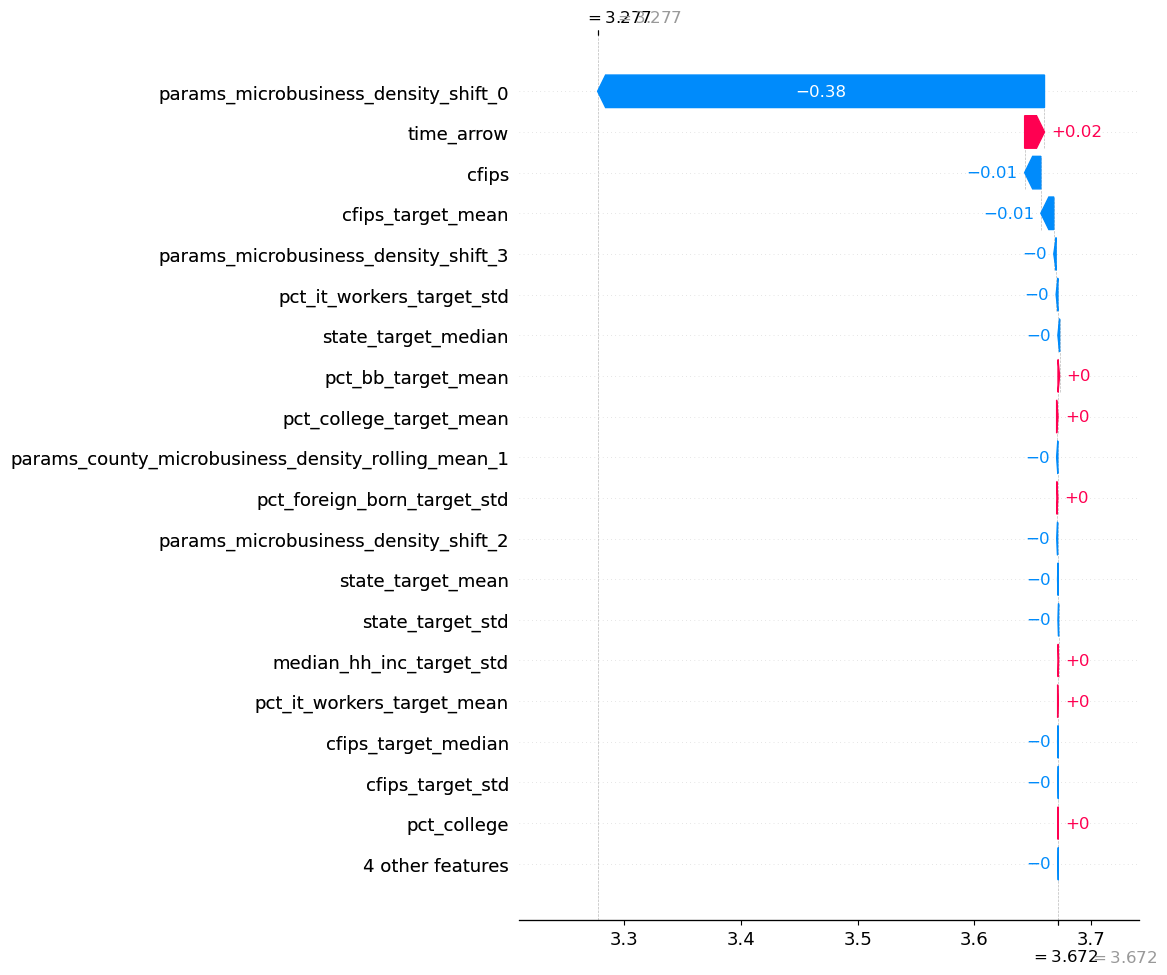

In [307]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,shap_values[1],
                                            feature_names=lgb_test.data.columns, max_display=20 )

In [300]:
t5

,col,shap_abs_value,index,param
2,params_microbusiness_density_shift_0,5968.994993,params_microbusiness_density_shift_0,1.000000
5,cfips,91.872668,NaN,NaN
7,time_arrow,68.023011,NaN,NaN
9,cfips_target_mean,42.989,NaN,NaN
8,cfips_target_median,15.475088,NaN,NaN
4,params_microbusiness_density_shift_3,7.300699,params_microbusiness_density_shift_3,7.336658
17,pct_bb_target_mean,5.853549,NaN,NaN
16,median_hh_inc_target_std,4.371848,NaN,NaN
19,pct_foreign_born_target_std,3.623309,NaN,NaN
18,pct_college_target_mean,3.604263,NaN,NaN


In [303]:
lgb_train.data[cols_to_use].columns.shape

(22,)

In [304]:
lgb_train.data[cols_w_params["col"].values].columns.shape

(22,)

In [305]:
set(lgb_train.data.columns) - set(lgb_train.data[cols_w_params["col"].values].columns)

{'pct_it_workers_target_median'}

In [276]:
# [bayes_params[x] for x in cols_to_use]

In [192]:
# t5[t5['param'] < 10]['col'].values

In [ ]:
# callbacks = build_callbacks(early_stopping=300)
# retrain_gbm = lgb.train(
#     model_params,
#     lgb_train,
#     callbacks=callbacks,
#     valid_sets=[lgb_eval],
#     feval=smape,
# )
# retrain_gbm.best_score

In [2]:
# gbm = lgb.Booster(model_file='../data/lgb/gbm')

# lgb_train = lgb.Dataset(data='../data/lgb/lgb_train').construct()
# lgb_train.data = pd.read_csv('../data/lgb/lgb_train_data', index_col='row_id')

# lgb_eval = lgb.Dataset(data='../data/lgb/lgb_eval').construct()
# lgb_eval.data = pd.read_csv('../data/lgb/lgb_eval_data', index_col='row_id')

# lgb_test = lgb.Dataset(data='../data/lgb/lgb_test').construct()
# lgb_test.data = pd.read_csv('../data/lgb/lgb_test_data', index_col='row_id')

# with open('../data/lgb/model_params', 'rb') as handle:
#     model_params = pickle.load(handle)

# with open('../data/lgb/bayes_params', 'rb') as handle:
#     bayes_params = pickle.load(handle)
    
# gbm.params = model_params

[LightGBM] [Info] Load from binary file ../data/lgb/lgb_train
[LightGBM] [Info] Load from binary file ../data/lgb/lgb_eval
[LightGBM] [Info] Load from binary file ../data/lgb/lgb_test


In [13]:
# # lgb_train = lgb.Dataset(data="../data/lgb/lgb_train", free_raw_data=False)
# cols_drop = [
#     "params_cfips_microbusiness_density_rolling_mean_1",
#     "params_cfips_microbusiness_density_rolling_mean_2",
#     "params_county_microbusiness_density_rolling_mean_1",
#     "params_county_microbusiness_density_rolling_mean_3",
#     "params_state_microbusiness_density_rolling_mean_0",
# ]
# train_2 = pd.read_csv("../data/lgb/lgb_train_data", index_col="row_id").drop(
#     columns=cols_drop
# )
# eval_2 = pd.read_csv("../data/lgb/lgb_eval_data", index_col="row_id").drop(
#     columns=cols_drop
# )
# lgb_train_2 = lgb.Dataset(data=train_2, label=lgb_train.label, free_raw_data=False)
# lgb_eval_2 = lgb.Dataset(data=eval_2, label=lgb_eval.label, free_raw_data=False)

# # lgb_train.data = t5

# # lgb_train.data = lgb_train.data.drop(columns=['params_microbusiness_density_shift_2'])

# callbacks = build_callbacks(early_stopping=300)
# retrain_gbm = lgb.train(
#     model_params,
#     lgb_train_2,
#     callbacks=callbacks,
#     valid_sets=[lgb_eval_2],
#     feval=smape,
# )
# retrain_gbm.best_score

Found `num_iterations` in params. Will use it instead of argument


defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('smape', 1.7828308253008274)])})

In [119]:
model_params['lambda_l2'] = 0

In [121]:
retrain_gbm.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('smape', 2.9308021197437006)])})

In [91]:
retrain_gbm.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('smape', 2.6187357133687557)])})

In [12]:
lgb_train.data.columns

Index(['params_cfips_microbusiness_density_rolling_mean_1',
       'params_cfips_microbusiness_density_rolling_mean_2',
       'params_county_microbusiness_density_rolling_mean_1',
       'params_county_microbusiness_density_rolling_mean_3',
       'params_state_microbusiness_density_rolling_mean_0',
       'params_state_microbusiness_density_rolling_mean_2',
       'params_microbusiness_density_shift_2', 'median_hh_inc', 'pct_bb',
       'pct_college', 'pct_foreign_born', 'pct_it_workers', 'state_target_std',
       'median_hh_inc_target_std', 'pct_college_target_median',
       'pct_college_target_std', 'pct_foreign_born_target_mean',
       'pct_it_workers_target_median'],
      dtype='object')

In [14]:
pred = gbm.predict(lgb_test.data.drop(columns=[]))
loss = smape(pred, lgb_test.label)
print('test loss', loss)

test loss ('smape', 1.7441399849281025, False)


In [7]:
gbm.predict(lgb_test.data)

array([3.28968721, 3.28968721, 3.28968721, ..., 1.83269057, 1.83269057,
       1.83269057])

In [8]:
lgb_test.label

array([3.2742248, 3.2922273, 3.3124802, ..., 1.8185124, 1.8185124,
       1.8366976], dtype=float32)

In [9]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(lgb_test.data)

In [45]:
shap_values[1]

array([-8.79465151e-05, -7.71566501e-06,  1.95347356e-04,  1.07430854e-05,
        2.24696229e-05, -1.90367641e-06, -4.10070392e-01,  4.04253746e-04,
        2.39971142e-04,  0.00000000e+00,  1.17488825e-04,  9.38167744e-05,
        3.80314022e-04,  5.40721127e-04,  5.83609985e-05,  6.93276759e-04,
        1.41992655e-03, -1.78868412e-04])

In [46]:
idx = list(lgb_test.data.columns).index('params_microbusiness_density_shift_2')
shap_values[1][idx]

-0.4100703920339652

In [54]:
shap_values.shape

(3110, 18)

In [74]:
t5 = pd.DataFrame([lgb_test.data.columns, shap_values.sum(axis=0)]).T
t5.columns = ['col', 'param']
t5

,col,param
0,params_cfips_microbusiness_density_rolling_mean_1,-0.162341
1,params_cfips_microbusiness_density_rolling_mean_2,0.03696
2,params_county_microbusiness_density_rolling_me...,-0.053676
3,params_county_microbusiness_density_rolling_me...,0.034938
4,params_state_microbusiness_density_rolling_mean_0,0.072779
5,params_state_microbusiness_density_rolling_mean_2,-0.022999
6,params_microbusiness_density_shift_2,-1282.600035
7,median_hh_inc,0.516017
8,pct_bb,-0.330587
9,pct_college,0.0


In [78]:
t5['param'].quantile(0.05)

-192.7378083388737

In [80]:
t5 = pd.DataFrame([lgb_test.data.columns, np.absolute(shap_values).sum(axis=0)]).T
t5.columns = ["col", "param"]
t5

,col,param
0,params_cfips_microbusiness_density_rolling_mean_1,0.629034
1,params_cfips_microbusiness_density_rolling_mean_2,0.255209
2,params_county_microbusiness_density_rolling_me...,0.568125
3,params_county_microbusiness_density_rolling_me...,0.606785
4,params_state_microbusiness_density_rolling_mean_0,0.252907
5,params_state_microbusiness_density_rolling_mean_2,0.531009
6,params_microbusiness_density_shift_2,6130.371683
7,median_hh_inc,1.308743
8,pct_bb,1.040736
9,pct_college,0.0


In [85]:
t5['param'].quantile(0.99)

5088.722018261274

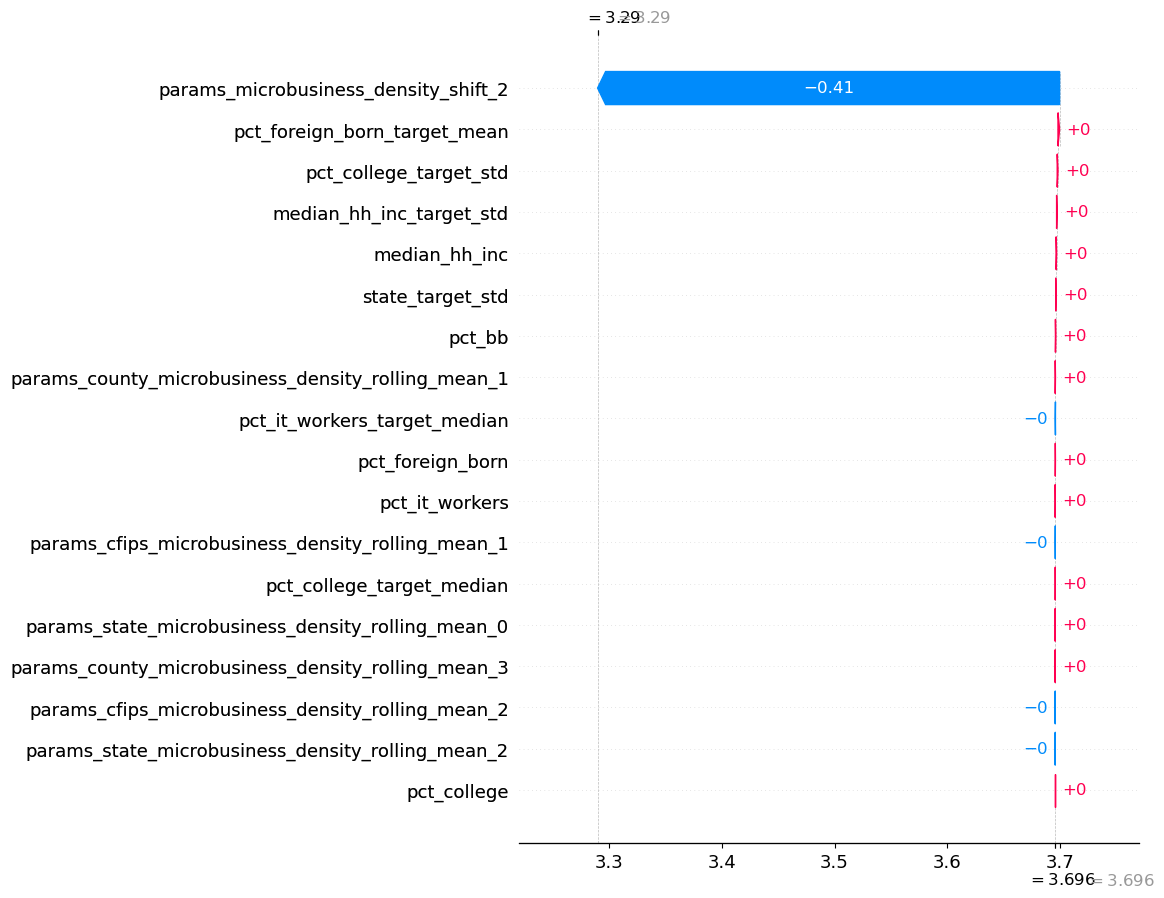

In [10]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,shap_values[1],
                                            feature_names=lgb_test.data.columns, max_display=20 )

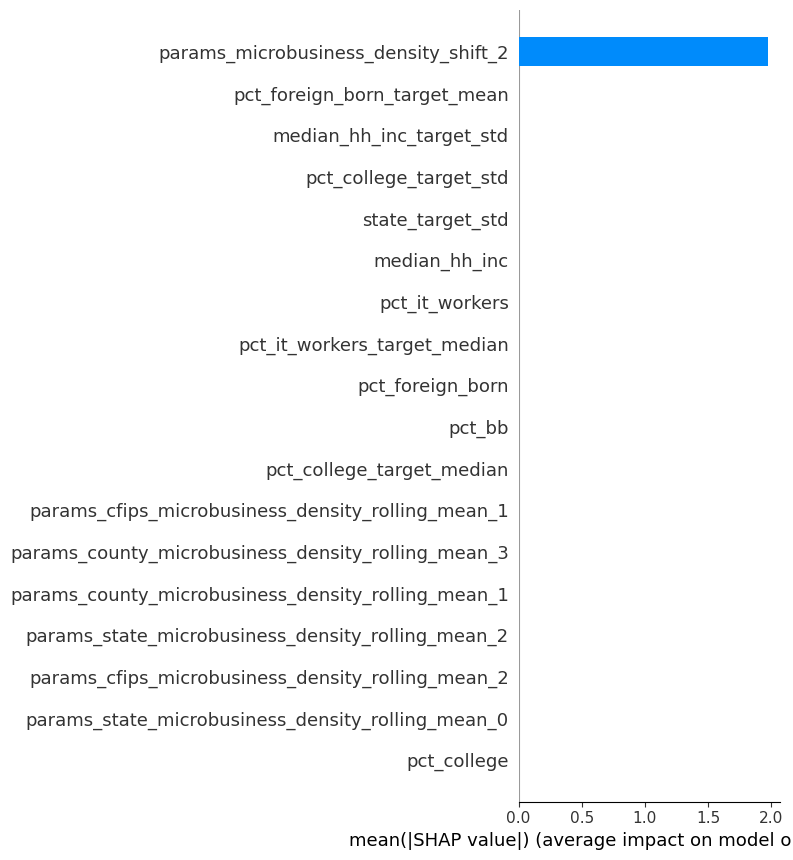

In [48]:
shap.summary_plot(shap_values, lgb_test.data, plot_type="bar", use_log_scale=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


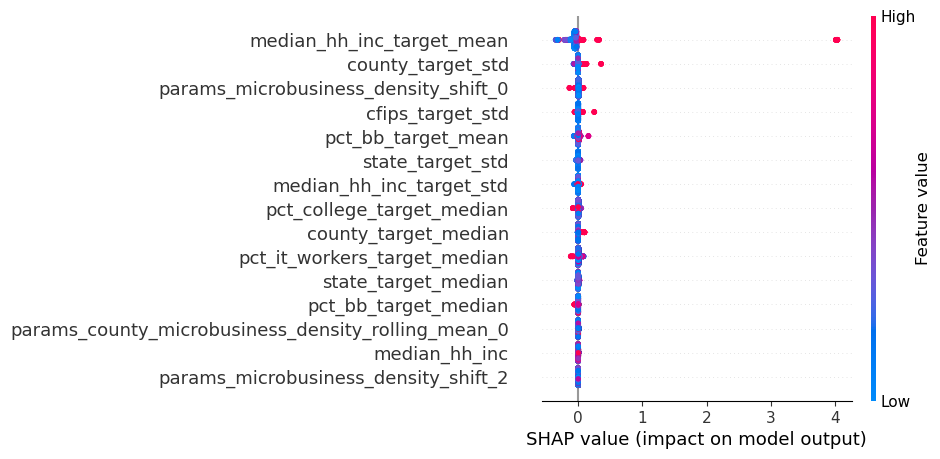

In [47]:
shap.summary_plot(shap_values[:, 1:], lgb_test.data[lgb_test.data.columns[1:]], plot_size=(5,5))

In [61]:
bayes_params

{'bagging_fraction': 1.25,
 'bagging_freq': 2.5690274845126955,
 'enabled_cfips_': 0.23360154359839588,
 'enabled_cfips_microbusiness_density_rolling_mean_0': -0.25421161299859313,
 'enabled_cfips_microbusiness_density_rolling_mean_1': 1.15,
 'enabled_cfips_microbusiness_density_rolling_mean_2': -0.3904145951255782,
 'enabled_cfips_microbusiness_density_rolling_mean_3': -1.237714867943306,
 'enabled_cfips_target_mean_': -1.2130315980019475,
 'enabled_cfips_target_median_': -0.005246888503673219,
 'enabled_cfips_target_std_': 1.15,
 'enabled_county_': -0.3454096343031302,
 'enabled_county_microbusiness_density_rolling_mean_0': 1.15,
 'enabled_county_microbusiness_density_rolling_mean_1': 0.336340324679848,
 'enabled_county_microbusiness_density_rolling_mean_2': -0.9015787420503671,
 'enabled_county_microbusiness_density_rolling_mean_3': 0.43381869849658755,
 'enabled_county_target_mean_': -1.078299155161704,
 'enabled_county_target_median_': 0.6445768945188624,
 'enabled_county_target_s

-0.12351100255745501


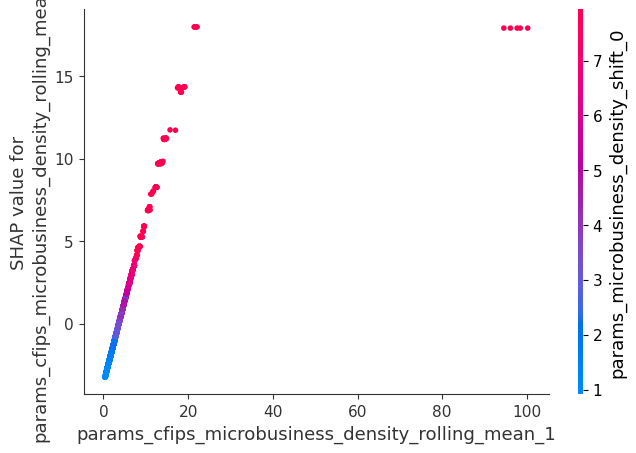

8.653947543774763


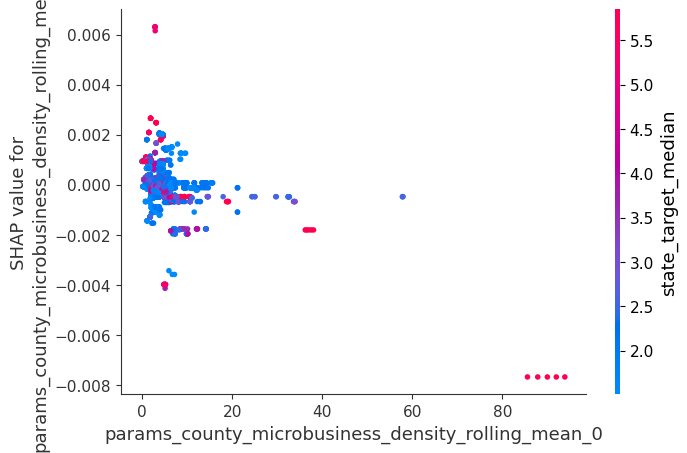

7.184163186713489


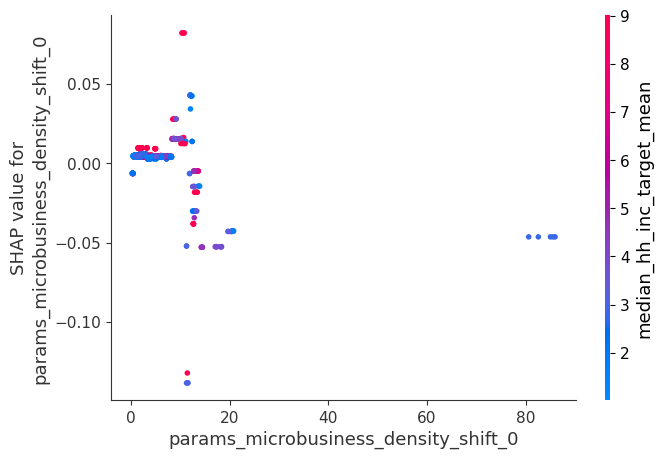

7.403667538422845


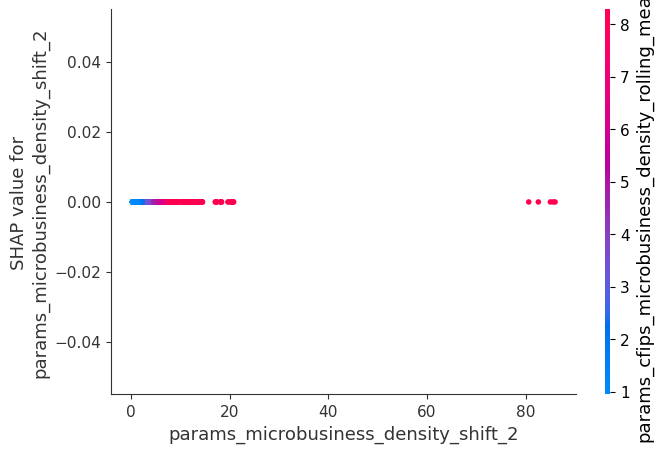

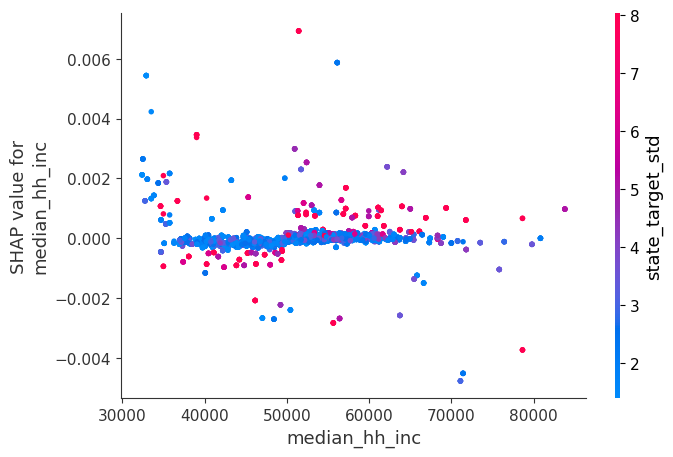

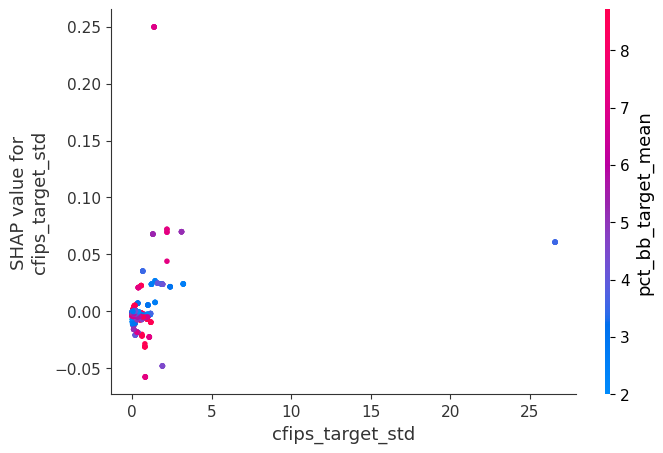

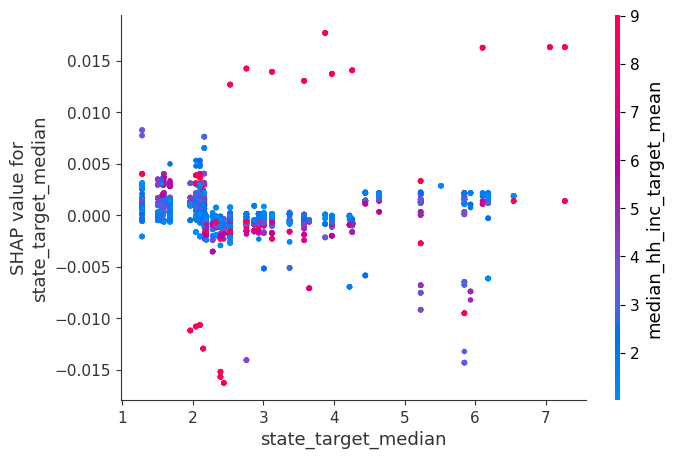

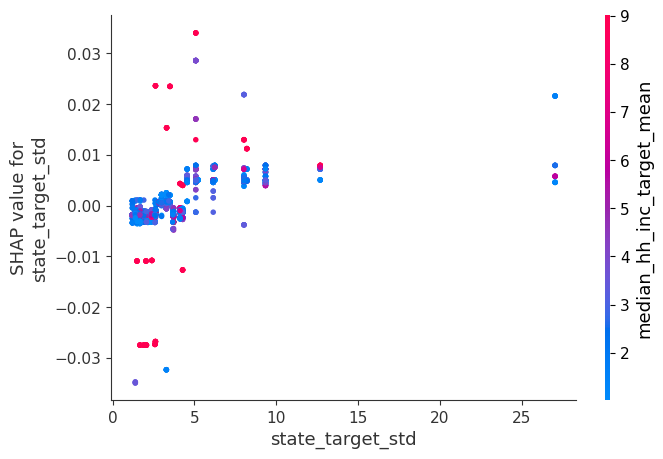

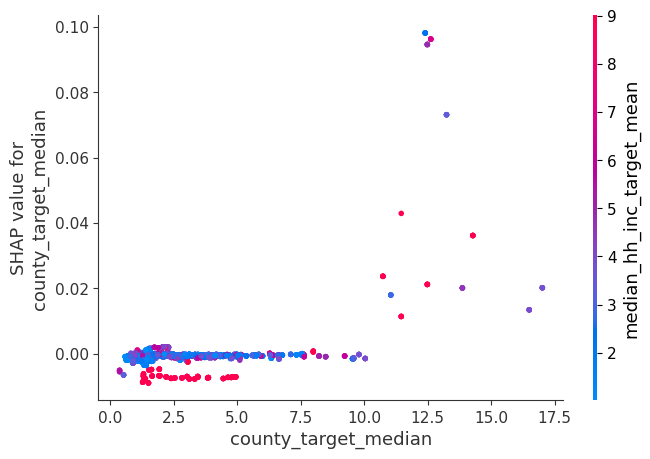

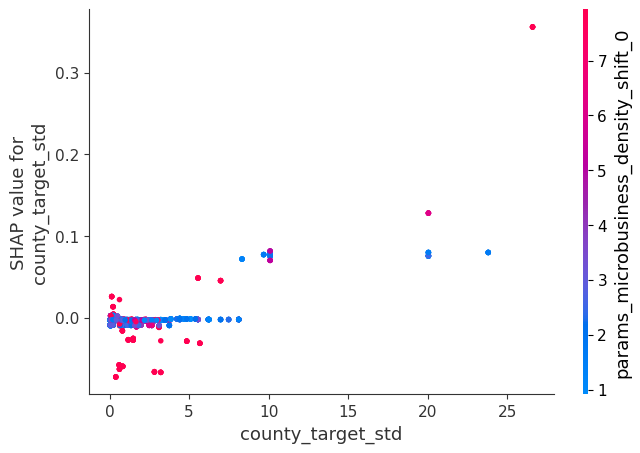

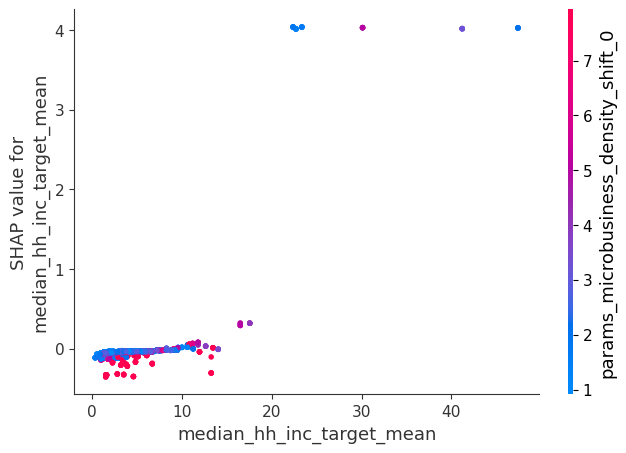

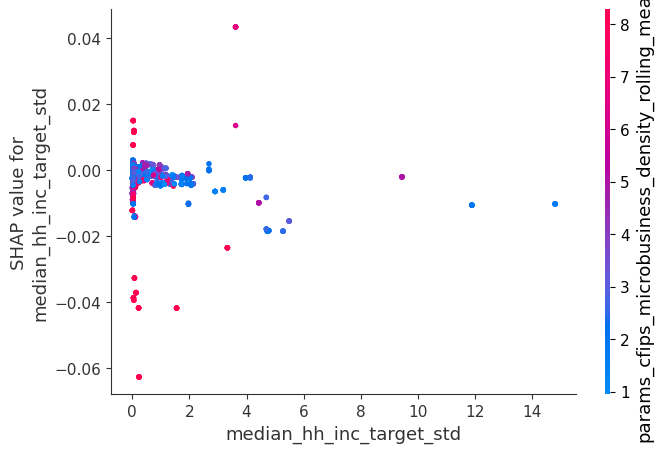

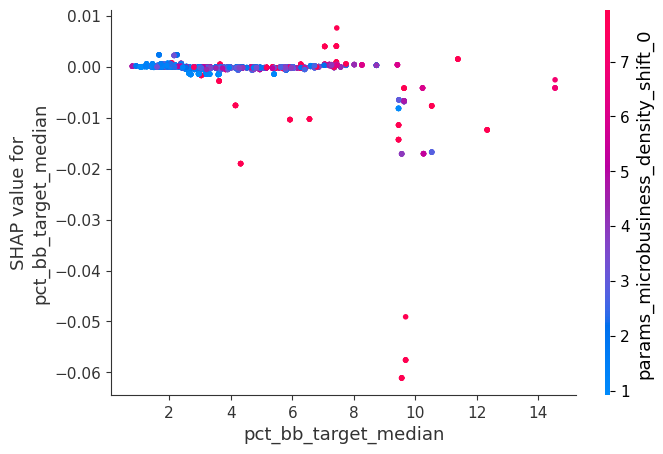

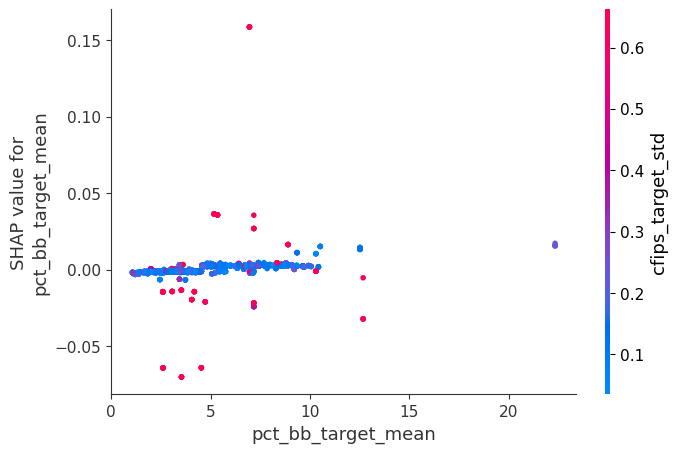

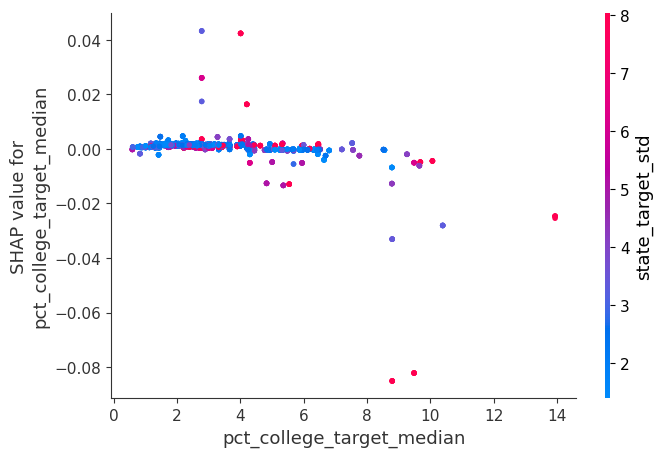

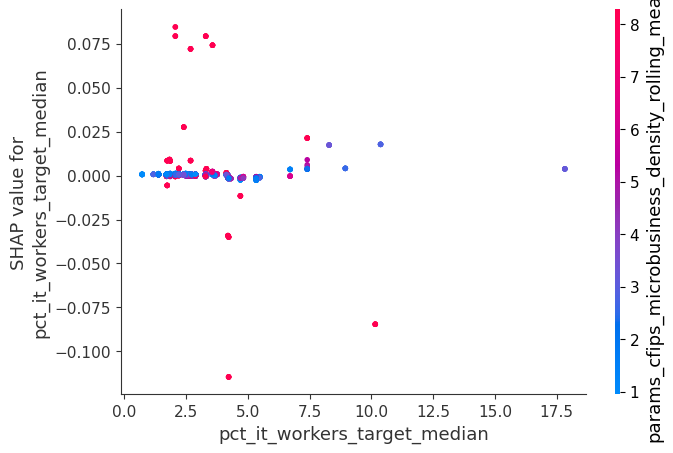

In [62]:
for col in  lgb_test.data.columns:
    if col in bayes_params:
        print(bayes_params[col])
    shap.dependence_plot(col, shap_values, lgb_test.data)

In [25]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

NameError: name 'X_display' is not defined

(3120, 16)

In [240]:
"""
1. Create a list of 15 first names
2. Create a list of 15 last names
3. Combine them randomly into a list of unique 11000 full russian names
"""

#1
first_names = ["Ivan", "Vladimir", "Sergei", "Alexander", "Dmitri", "Alexei", "Anton", "Mikhail", "Nikolai", "Pavel", "Evgeny", "Andrey", "Konstantin", "Yuri", "Vladislav"]

#2
last_names = ["Kuznetsov", "Ivanov", "Petrov", "Sidorov", "Kozlov", "Popov", "Vasiliev", "Morozov", "Lebedev", "Sokolov", "Mikhailov", "Novikov", "Kalinin", "Smirnov", "Volkov"]

#3
import random

russian_names = []

for i in range(110):
    russian_name = random.choice(first_names) + " " + random.choice(last_names)
    if russian_name not in russian_names:
        russian_names.append(russian_name)
    else:
        while russian_name in russian_names:
            russian_name = random.choice(first_names) + " " + random.choice(last_names)
        russian_names.append(russian_name)

print(russian_names)

['Alexander Novikov', 'Alexander Kuznetsov', 'Nikolai Ivanov', 'Alexei Volkov', 'Alexander Sidorov', 'Anton Kozlov', 'Ivan Volkov', 'Vladislav Vasiliev', 'Yuri Volkov', 'Alexei Sidorov', 'Sergei Morozov', 'Konstantin Vasiliev', 'Vladimir Mikhailov', 'Andrey Petrov', 'Andrey Popov', 'Evgeny Sidorov', 'Alexander Petrov', 'Anton Volkov', 'Dmitri Sokolov', 'Andrey Kuznetsov', 'Konstantin Smirnov', 'Sergei Mikhailov', 'Andrey Kalinin', 'Vladimir Sidorov', 'Konstantin Novikov', 'Sergei Sokolov', 'Ivan Lebedev', 'Andrey Mikhailov', 'Ivan Kozlov', 'Vladislav Sidorov', 'Mikhail Kuznetsov', 'Andrey Novikov', 'Vladislav Mikhailov', 'Nikolai Kozlov', 'Andrey Kozlov', 'Alexander Kalinin', 'Yuri Kuznetsov', 'Pavel Sokolov', 'Mikhail Mikhailov', 'Nikolai Volkov', 'Alexei Novikov', 'Anton Kuznetsov', 'Anton Petrov', 'Pavel Sidorov', 'Pavel Kozlov', 'Pavel Novikov', 'Alexei Petrov', 'Andrey Morozov', 'Andrey Ivanov', 'Vladimir Kuznetsov', 'Ivan Kalinin', 'Sergei Kozlov', 'Pavel Kalinin', 'Pavel Petrov'

In [241]:
np.array(russian_names).shape

(110,)

In [242]:
np.unique(np.array(russian_names)).shape

(110,)